In [1]:
import numpy as np

from tqdm import tqdm, trange
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('utilities/')
import load_data
import utils

First let's load up the data. You can select one of the four premade datasets below and our utilities will do the rest. 

In [2]:
num_pos = 5000
num_neg = 5000
problem_range = np.array([[-1,1], [-1,1]])

#Dataset 1: Six data modes with constraint at center of each mode
sampling_func = load_data.sample_circle_blobs_wrapper(num_pos, num_neg, 6, 0.7, 0.1)
validity_func = load_data.inv_radial_circles_val_wrapper(0.7, 0.04, 6)

#Dataset 2: Uniform distribution with grid of circular constraints
# sampling_func = load_data.sample_uniform_wrapper(num_pos, num_neg)
# validity_func = load_data.circles_val_wrapper(0.25, 2)

#Dataset 3: Plus-shaped constraint
# sampling_func = load_data.sample_gaussian_wrapper(1000, 1000, 0.3)
# validity_func = load_data.plus_val_wrapper(0.5, 0.1)

#Dataset 4: Uniform distribution with six radial circular constraints
# sampling_func = load_data.sample_uniform_wrapper(1000, 1000)
# validity_func = load_data.inv_radial_circles_val_wrapper(0.7, 0.1, 6)

datasetfunction = load_data.get_dataset_func(sampling_func, validity_func, problem_range)
P, _, N, _, _= load_data.gen_dataset(datasetfunction, 0, False)
P, N = sampling_func(validity_func, problem_range)

Let's take a look at the data that we loaded:

Text(0.5, 1.0, 'Negative Data')

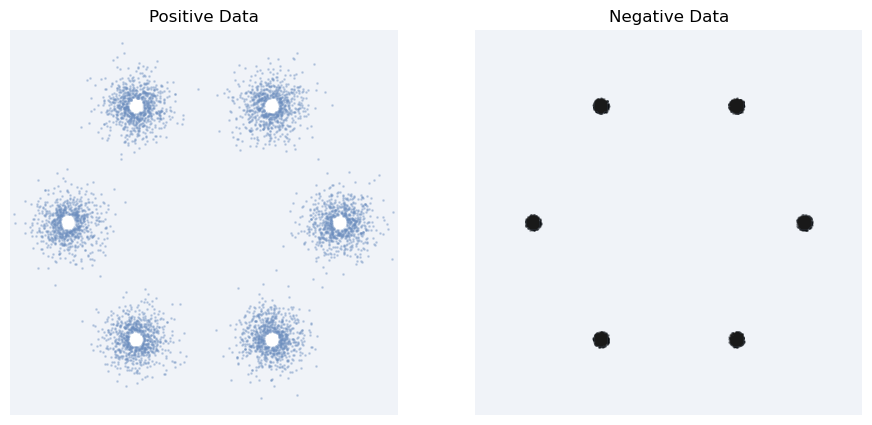

In [3]:
maincolor = "#6C8EBF"
xx, yy, Z = utils.gen_background_plot(validity_func, problem_range)
cmap = LinearSegmentedColormap.from_list("", ["#FFFFFF", maincolor], N=2)

def formatplot(ax, problem_range):
    ax.axis("off")
    ax.set_xlim(problem_range[0][0], problem_range[0][1])
    ax.set_ylim(problem_range[1][0], problem_range[1][1])

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

ax = axes[0]
ax.scatter(P[:,0], P[:,1], c = maincolor, s=1, alpha=0.3)
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
formatplot(ax, problem_range)
ax.set_title("Positive Data")

ax = axes[1]
ax.scatter(N[:,0], N[:,1], c = "k", s=1, alpha=0.3)
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
formatplot(ax, problem_range)
ax.set_title("Negative Data")

Let's set up our model. We have set up a training function that takes in a set of parameters and settings. The parameters is a list of: [batch_size, G_LR, D_LR, A_LR, noise_dim, epochs, n_hidden, layer_size]. The settings is a list of train_step_type, validity weight, and diversity weight. 

Here are the training options that we have implemented:

Vanilla GAN: "GAN_vanilla"

Class Conditional GAN: "GAN_cond"

GAN with pretrained classifier loss: "GAN_pre"

GAN with rejection sampling: "GAN_rej"

GAN with Discriminator Overloading: "GAN_DO"

GAN with Multiclass Discriminator + Diversity: "GAN_MDD"

GAN with Double Discriminator + Diversity: "GAN_DDD"

Vanilla VAE: "VAE_vanilla"

Class Conditional VAE: "VAE_cond"

VAE with pretrained classifier loss: "VAE_pre"

VAE with rejection sampling: "VAE_rej"

Vanilla DDPM: "DDPM_vanilla"

Class Conditional DDPM: "DDPM_cond"

DDPM with rejection sampling: "DDPM_rej"

DDPM with Classifier Guidance: "DDPM_guid"





In [4]:
import models_torch

#Training paramereters: [batch_size, G_LR, D_LR, A_LR, noise_dim, epochs, n_hidden, layer_size]
train_params = [256, 3e-4, 3e-4, 3e-4, 8, 10000, 1, 400]

#Training settings: [model_type, validity weight, diversity weight]
training_settings = ["GAN_MDD", None, 0.1]
train_fn = models_torch.train_wrapper(train_params, training_settings)

In [5]:
res, _= train_fn(X=P, N=N, numgen=5000)
generated = res[0]

100%|██████████| 195312/195312 [38:16<00:00, 85.05it/s, L_D_real=0.7715, L_D_neg=0.1165, L_D_fake=0.6880, L_G=0.7583, L_div=14.3811]


Text(0.5, 1.0, 'Generated Data')

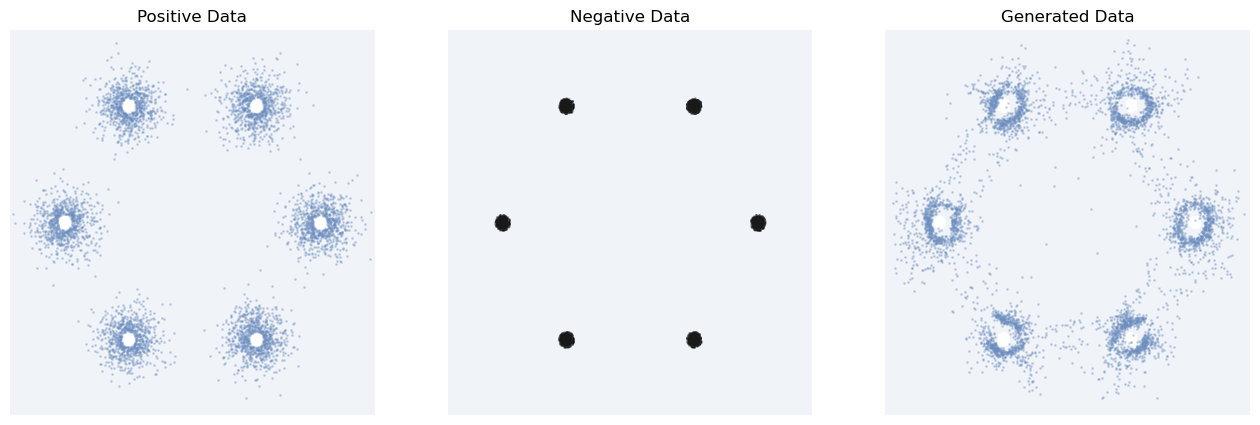

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

ax = axes[0]
ax.scatter(P[:,0], P[:,1], c = maincolor, s=1, alpha=0.3)
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
formatplot(ax, problem_range)
ax.set_title("Positive Data")

ax = axes[1]
ax.scatter(N[:,0], N[:,1], c = "k", s=1, alpha=0.3)
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
formatplot(ax, problem_range)
ax.set_title("Negative Data")

ax = axes[2]
ax.scatter(generated[:,0], generated[:,1], c = maincolor, s=1, alpha=0.3)
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
formatplot(ax, problem_range)
ax.set_title("Generated Data")